# Introducution

* Hello, my name is Shorter
* This is my project detailing the process undertaken to predict home values using 2017 Zillow home information

## Project Objective 
> Document code, process data (through entire pipeline), and articulate key findings and takeways in a jupyter notebook final report 
* Create modules that faciliate project repeatability, as well as final report readability
> Ask/Answer exploratory questions of data and attributes to understand drivers of home value  
* Utilize charts and statistical tests
> Construct models to predict assessed home value for single family properties using regression techniques
> Make recommendations

## Project Business Goals
> Construct ML Regression model that accurately predicts property tax assessed values (`taxvaluedollarcnt` -> home value) of *Single Family Properties* using attributes of the properties? </br>
> Find key drivers of property value for single familty properties</br>
> Deliver report that the data science team can read through and replicate, while understanding what steps were taken, why and what the outcome was.
> Make recommendations on what works or doesn't work in predicting these homes' values

### Executive Summary
* Large numbers of homes in LA County fit the profile for lower value homes:
    - Smaller, older, less rooms, and higher taxes
* Need much more robust feature set for modeling

# Import Section

In [1]:
#### Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wrangle import prep, acquire_zillow
from model import modeling_prep, train_score, pf_mod

from itertools import product
from scipy.stats import levene , pearsonr, spearmanr, mannwhitneyu, f_oneway, ttest_ind
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression, SelectKBest

import warnings
warnings.filterwarnings("ignore")


Number of observations removed: 10899


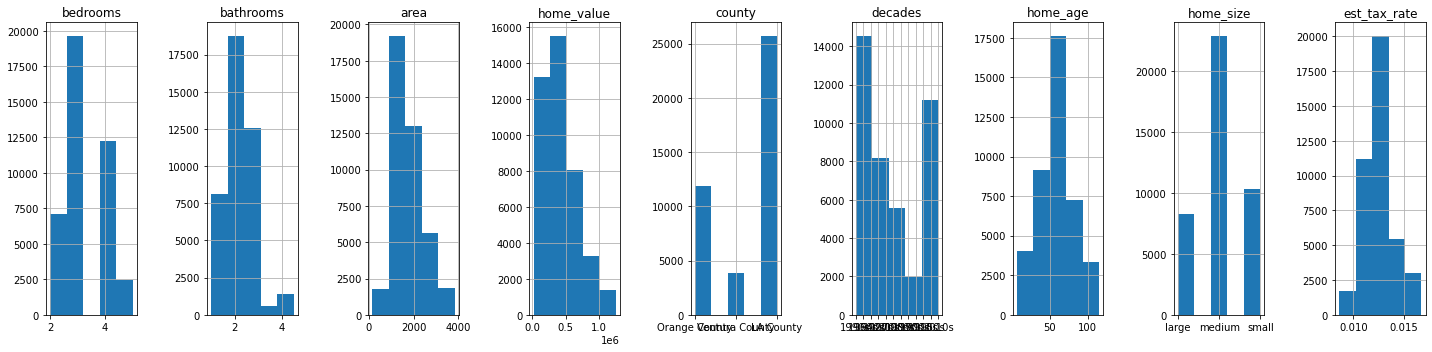

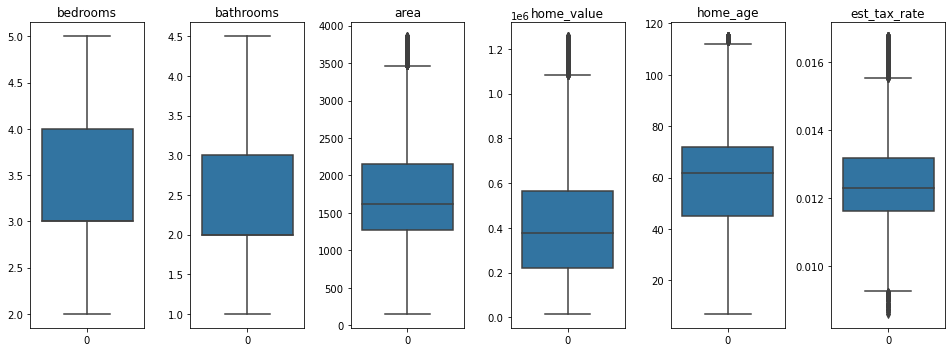

In [2]:
#calling prepare/acquire functions from module to acruire data subsets
df, train, train_scaled, validate, validate_scaled, test, test_scaled = prep(acquire_zillow())

## Exploration Questions with plots and tests

### Question - Is there difference in median home value between counties?
${H_0}$: There is no significant difference in median home value between counties  
${H_a}$: There is significant difference in median home value between counties  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

In [3]:
#show list of m
round(train.groupby(by='county').home_value.median().sort_values(ascending=False) ,2)

county
Orange County     446617.0
Ventura County    430500.0
LA County         335219.0
Name: home_value, dtype: float64

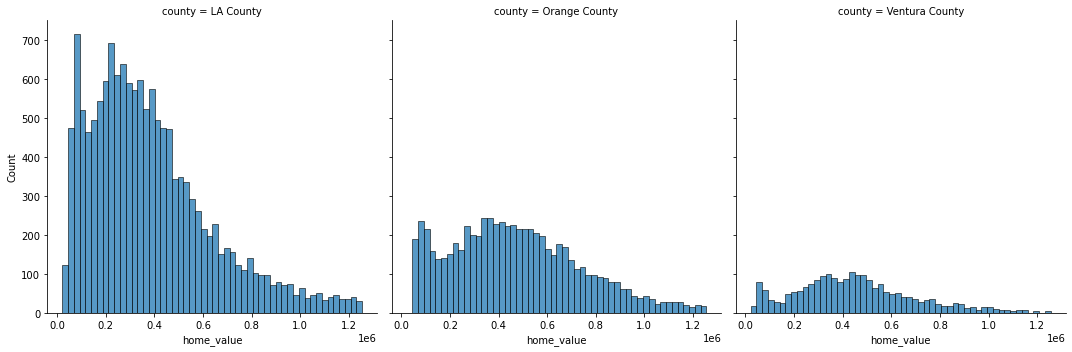

In [4]:
#visualization of home value distributions
sns.displot(data=train, x='home_value', col='county', kind='hist');

In [5]:
#split home values by country for ANOVA comparison
la_county = train[train.county == 'LA County'].home_value
orange_county = train[train.county == 'Orange County'].home_value
ventura_county = train[train.county == 'Ventura County'].home_value

#set alpha for statistical test, plug values into f_oneway function
alpha = .05
f, p = f_oneway(la_county, orange_county, ventura_county)

print (f'ANOVA test statistic value: {f}')
print (f'p-value : {p}')

#comparison for p and alpha to decide outcome
if p > alpha:
    print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
else: 
    print(f'There is enough evidence to reject our null hypothesis')

ANOVA test statistic value: 296.5808060407762
p-value : 6.552208990337671e-128
There is enough evidence to reject our null hypothesis


### Question -  Why do some properties have a much higher value than others when they are located so close to each other? 

#### Visualization - Home Values against home age split by counties

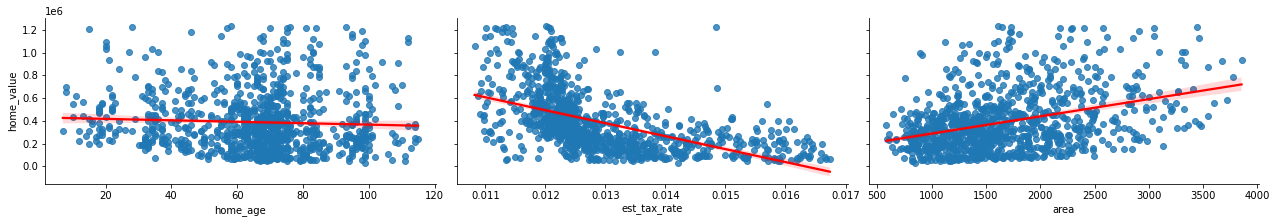

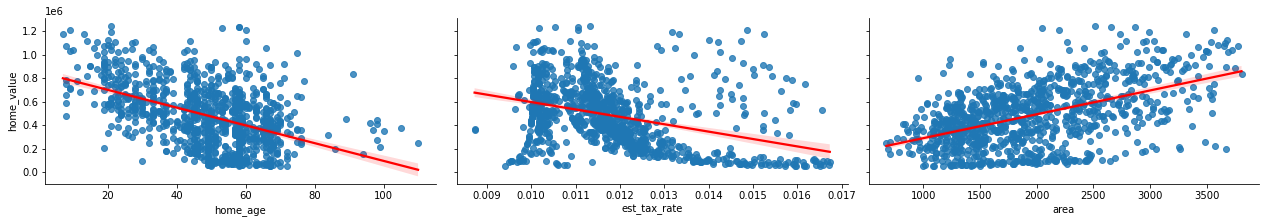

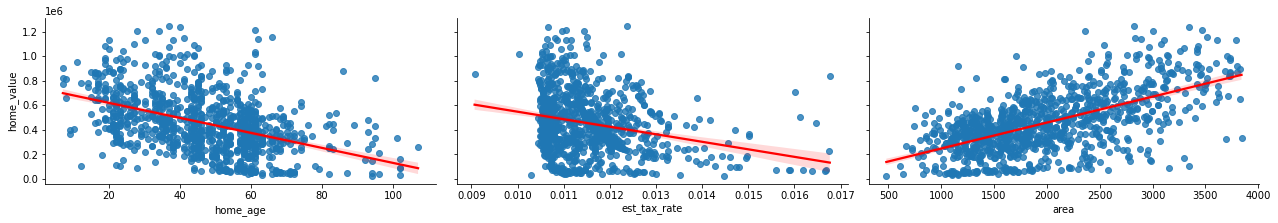

In [6]:
# loop through visualizations of each county to show relationship between home age, est tax rate, and area
for county in ['LA County', 'Orange County', 'Ventura County']:
    g = sns.PairGrid(data=train[train.county == county].sample(n=1000),
                    y_vars='home_value', x_vars=['home_age', 'est_tax_rate', 'area'],
                    height=3, aspect=2)
    g.map(sns.regplot, line_kws={'color':'r'}, label=county)

### Takeaway
* Across counties home age and estimated tax rate have negative correlations. 
    * Area with most weakeast home age correlation is LA County.
* Area has a positive correlation in all counties

In [7]:
#set alpha to .05
alpha = .05

#loop for testing correlation between home value and home age/estimated tax rate/area
for col in ['home_age', 'est_tax_rate', 'area']:

    # pearson test and decision
    r, p = pearsonr(train[col], train.home_value)
    if p > alpha:
        result = 'Fail to reject the null hypothesis, because our p-value is greater than our alpha.'
    else: 
        result = 'There is enough evidence to reject our null hypothesis'

    print(f""" 
    H_0: There is no relationship between home value and {col}
    H_a: There is a relationship between home value and {col}
    alpha: .05
    Pearson r value: {r}
    p-value : {p}
    {result}
    -----""")

 
    H_0: There is no relationship between home value and home_age
    H_a: There is a relationship between home value and home_age
    alpha: .05
    Pearson r value: -0.251367782193178
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----
 
    H_0: There is no relationship between home value and est_tax_rate
    H_a: There is a relationship between home value and est_tax_rate
    alpha: .05
    Pearson r value: -0.4692591801779151
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----
 
    H_0: There is no relationship between home value and area
    H_a: There is a relationship between home value and area
    alpha: .05
    Pearson r value: 0.46319756420051295
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----


In [8]:
# area has a high correlation with property value
alpha = .05
for county in ['LA County', 'Orange County', 'Ventura County']:
    print(f'In {county}:')
    for col in ['home_age', 'est_tax_rate', 'area']:
        r, p = pearsonr(train[train.county == county][col], train[train.county == county].home_value)
        if p > alpha:
            result = 'Fail to reject the null hypothesis, because our p-value is greater than our alpha.'
        else: 
            result = 'There is enough evidence to reject our null hypothesis'

        print(f""" 
        H_0: There is no relationship between median home value and {col}
        H_a: There is a relationship between median home value and {col}
        alpha: .05
        Pearson r value: {r}
        p-value : {p}
        {result}
        -----""")

In LA County:
 
        H_0: There is no relationship between median home value and home_age
        H_a: There is a relationship between median home value and home_age
        alpha: .05
        Pearson r value: -0.08466487313626364
        p-value : 3.2328506334010425e-24
        There is enough evidence to reject our null hypothesis
        -----
 
        H_0: There is no relationship between median home value and est_tax_rate
        H_a: There is a relationship between median home value and est_tax_rate
        alpha: .05
        Pearson r value: -0.5209255495897032
        p-value : 0.0
        There is enough evidence to reject our null hypothesis
        -----
 
        H_0: There is no relationship between median home value and area
        H_a: There is a relationship between median home value and area
        alpha: .05
        Pearson r value: 0.3817707752076994
        p-value : 0.0
        There is enough evidence to reject our null hypothesis
        -----
In Orange Cou

### Question -  Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location?



In [9]:
#show the estimated tax rate for each county
round(train.groupby(by='county').est_tax_rate.mean().sort_values(ascending=False) ,3)

county
LA County         0.013
Orange County     0.012
Ventura County    0.011
Name: est_tax_rate, dtype: float64

#### Visualization - Home Values among different sizes sepearted by counties as colors, and regression lines tracking estimated tax rate

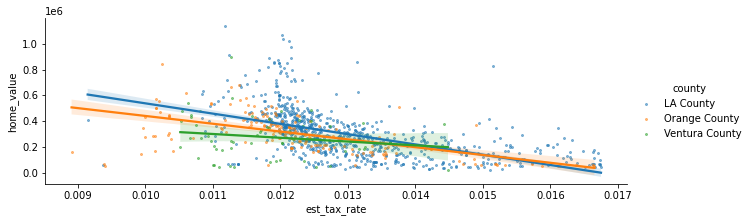

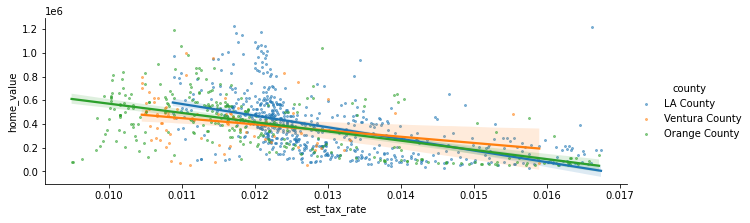

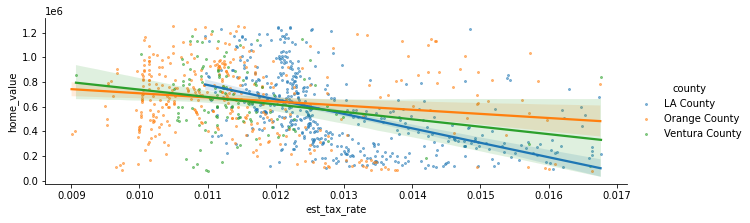

In [10]:
#loop through home sizes to show comparison between home_value and estimated tax rate across sizes. hue is based on county to how lack of difference
for size in ['small', 'medium', 'large']:
    g = sns.PairGrid(data=train[train.home_size == size].sample(n=1000),
                    y_vars='home_value', x_vars=['est_tax_rate'],
                    hue='county', height=3, aspect=3)
    g.map(sns.regplot, scatter_kws = {'alpha': 0.5,'s':4})
    g.add_legend()

In [11]:
# set alpha to .05
alpha = .05

#statistical tests for correlation between estimated tax rate and home value across home sizes
for size in ['small', 'medium', 'large']:
    print(f'Among {size} homes:')
    r, p = pearsonr(train[train.home_size == size]['est_tax_rate'], train[train.home_size == size].home_value)
    if p > alpha:
        result = 'Fail to reject the null hypothesis, because our p-value is greater than our alpha.'
    else: 
        result = 'There is enough evidence to reject our null hypothesis'

    print(f""" 
    H_0: There is no relationship between mean home value and estimated tax rate.
    H_a: There is a relationship between mean home value and estimated tax rate.
    alpha: .05
    Pearson r value: {r}
    p-value : {p}
    {result}
    -----""")

Among small homes:
 
    H_0: There is no relationship between mean home value and estimated tax rate.
    H_a: There is a relationship between mean home value and estimated tax rate.
    alpha: .05
    Pearson r value: -0.495171052696178
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----
Among medium homes:
 
    H_0: There is no relationship between mean home value and estimated tax rate.
    H_a: There is a relationship between mean home value and estimated tax rate.
    alpha: .05
    Pearson r value: -0.49317912485896725
    p-value : 0.0
    There is enough evidence to reject our null hypothesis
    -----
Among large homes:
 
    H_0: There is no relationship between mean home value and estimated tax rate.
    H_a: There is a relationship between mean home value and estimated tax rate.
    alpha: .05
    Pearson r value: -0.36722405188931806
    p-value : 3.824945187982036e-148
    There is enough evidence to reject our null hypothesis
    ----

### Takeaways
* There is distinct negative correlation between estimated tax rate and home value across sizes and counties 

### Question - Is having one bathroom worse than having two bedrooms?


#### Visualization - Home Values among different home sizes and with groupings based on number of bathrooms and bedrooms

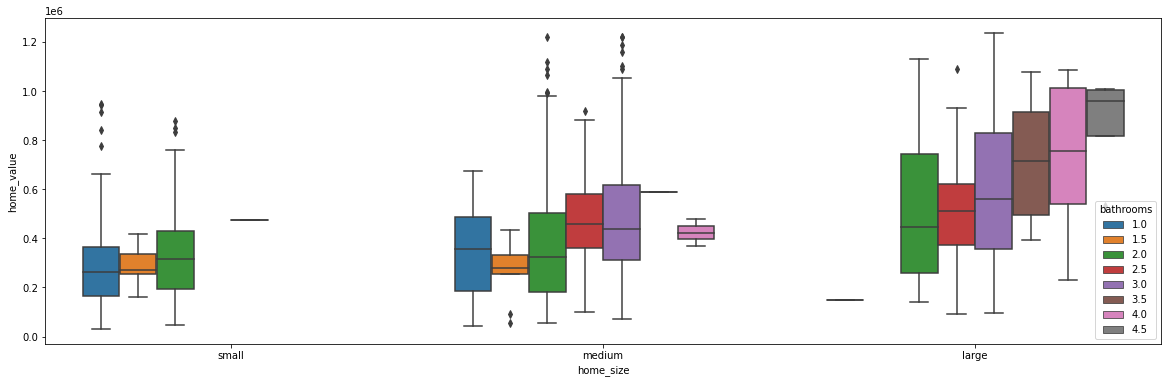

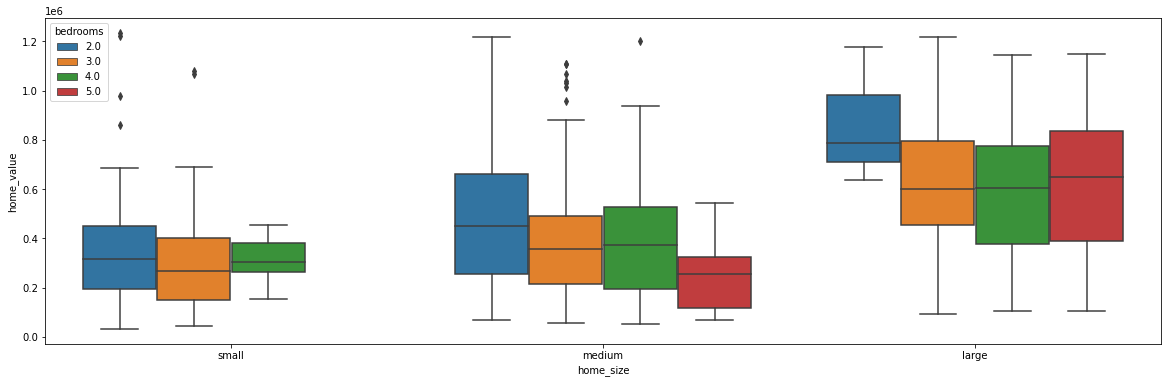

In [12]:
#loop through columns to create visual comparing home values across differences in size groups 
for col in train[['bathrooms', 'bedrooms']].columns:
    plt.figure(figsize=(20,6))
    sns.boxplot(data=train.sample(n=1000), x='home_size', y='home_value',
                hue=col) 
    plt.show()

In [13]:
#create series containing the home values of the subgroups in question
one_bathroom = train[train.bathrooms == 1].home_value
two_bedrooms = train[train.bedrooms == 2].home_value

print(f'Mean home value of homes with one bathroom: {round(one_bathroom.mean(),2)}\n\
Mean home value of homes with two bedrooms: {round(two_bedrooms.mean(),2)}')

Mean home value of homes with one bathroom: 301604.7
Mean home value of homes with two bedrooms: 343753.04


In [14]:
#set alpha
alpha = .05

#perform levene tets
l, p = levene(one_bathroom, two_bedrooms)

print (f'Levene test statistic value: {f}')
print (f'p-value : {p}')

#check p against alpha
if p > alpha:
    print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
else: 
    print(f'There is enough evidence to reject our null hypothesis')

Levene test statistic value: 296.5808060407762
p-value : 2.1705383432926296e-15
There is enough evidence to reject our null hypothesis


### Takeaways
* It is better to have two bedrooms than one bathroom
* That however seems to tied to the fact that more bedrooms are associated with larger homes, rather than the bedrooms being a driver

# Modeling

In [15]:
#call modeling preparation function to acquire train/validate/test subsets
X_train, y_train, X_val, y_val, X_test, y_test = modeling_prep(train, train_scaled, validate, validate_scaled, test, test_scaled)

In [16]:
#model and score various functions and find list of best three performing
top_three = train_score(X_train, y_train).sort_values(by='r^2 score', ascending=False).head(3)

In [17]:
top_three

,RMSE,r^2 score,Features,Parameters
Name,,,,
Polynomial_2,174798.934506,0.55,"[bedrooms, bathrooms, area, home_age, est_tax_...",Degree: 3
Polynomial_12,180705.049991,0.51,"[est_tax_rate, area, bathrooms, home_age, coun...",Degree: 3
Polynomial_10,181140.596244,0.51,"[est_tax_rate, area, home_age, county_Orange C...",Degree: 3


## Three Best Models ran on Validation Set
* Polynomials 2 
    - Degrees: 3
    - Features: All
* Polynomial 12
    - Degrees: 3
    - Fetures: estimated tax rate, area, home age, and county
* Polynomial 10
    - Degrees: 3
    - Features: estimated tax rate, area, bathrooms, home age, and county


In [26]:
#create lists of features
all_features = list(X_train.columns)

feat_set3 = ['est_tax_rate', 'area', 'home_age', 'county_Orange County', 'county_Ventura County']

feat_set4 = ['est_tax_rate', 'area', 'bathrooms', 'home_age', 'county_Orange County', 'county_Ventura County']

#select features and degree level for model testing on validation set
val_selectors = [(all_features, 3), (feat_set3, 3), (feat_set4, 3)]

#call pf function to get predictions for the Polynomial models and add to the dataframe
print(pf_mod(X_val, y_val, val_selectors, X_train, y_train))

#create dataframe to hold model scores
validate_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

for idx, model in enumerate(y_val.drop(columns='home_value').columns):
    score = explained_variance_score(y_val['home_value'], y_val[model])
    validate_scores.loc[idx] = [model, score]

           Name                 RMSE  \
0  Polynomial_1  58279225909394752.0   
0  Polynomial_2        182327.056692   
0  Polynomial_3        182006.080466   

                                            Features Parameters  
0  [bedrooms, bathrooms, area, home_age, est_tax_...  Degree: 3  
0  [est_tax_rate, area, home_age, county_Orange C...  Degree: 3  
0  [est_tax_rate, area, bathrooms, home_age, coun...  Degree: 3  


In [19]:
validate_scores['r^2 Score'] = validate_scores['r^2 Score'].astype('float64')

In [20]:
for idx in validate_scores.index:
     if validate_scores.loc[idx, 'Model'] == 'Polynomial_1':
          validate_scores.loc[idx, 'Model'] = 'Polynomial_2'
     elif validate_scores.loc[idx, 'Model'] == 'Polynomial_2':
          validate_scores.loc[idx, 'Model'] = 'Polynomial_12'
     elif validate_scores.loc[idx, 'Model'] == 'Polynomial_3':
          validate_scores.loc[idx, 'Model'] = 'Polynomial_10'

In [21]:

round(validate_scores, 2)


,Model,r^2 Score
0,pred_median,0.000000e+00
1,Polynomial_2,-4.966612e+22
2,Polynomial_12,5.100000e-01
3,Polynomial_10,5.200000e-01


## Test
* Polynomial 10
    - Degrees: 3
    - Features: estimated tax rate, area, bathrooms, home age, and county

 ### Model Code       
        pf_descriptions = pd.DataFrame({}, columns=['Name','RMSE', 'Features', 'Parameters'])

        for idx, combo in enumerate(selectors):
            pf = PolynomialFeatures(degree=combo[1])

            lm = LinearRegression(normalize=True)

            if fit_train is not None:
                fit_pf = pf.fit_transform(fit_train[combo[0]])
                X_pf = pf.transform(X[combo[0]])  
                lm.fit(fit_pf, fit_y_train.home_value)
            else:
                X_pf = pf.fit_transform(X[combo[0]])
                lm.fit(X_pf, y.home_value)

            model_label = f'Polynomial_{idx+1}'

            #predict train
            y[model_label] = lm.predict(X_pf) 

            #calculate train rmse
            rmse = mean_squared_error(y.home_value, y[model_label], squared=False)

            # print(f'{model_label} with degree: {combo[1]} \n\
            #     Features: {combo[0]} \n\
            #     RMSE: {rmse}\n')
            
            description = pd.DataFrame([[model_label, rmse, combo[0], f'Degree: {combo[1]}']], columns=['Name', 'RMSE', 'Features', 'Parameters'])
            pf_descriptions = pd.concat([pf_descriptions, description])

        return pf_descriptions

In [22]:
#select features and degree level for model testing on test set
test_selectors = [(feat_set4, 3)]

#run function to use model to on test set
pf_mod(X_test, y_test, test_selectors, X_train, y_train)

,Name,RMSE,Features,Parameters
0,Polynomial_1,454892.9766,"[est_tax_rate, area, bathrooms, home_age, coun...",Degree: 3


In [23]:
#create dataframe to hold model scores
test_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

for idx, model in enumerate(y_test.drop(columns='home_value').columns):
    score = explained_variance_score(y_test['home_value'], y_test[model])
    test_scores.loc[idx] = [model, score]

test_score = explained_variance_score(y_test['home_value'], y_test[model])


In [24]:
test_score

-782631831999.6567

# Conclusion

## Summary of Key Findings
* Bedrooms, bathrooms, home_size/area and lower age support higher home values
* Large numbers of homes in LA County 
* Estimated Tax rate has negative correlation with home value

## Suggestions and Next Steps
* No suggestions this time as the model does not beat baseline predictions
* Take a look at adding distance relationships
    - Distance from: water, schools, parks, etc. 
* Explore garages and other add-on data such as pools
    - Be willing to impute more data
* Investigate walk/bike/transit scores
* May consider creating county specific models
* Take steps to correct or add null/missing data from properties